In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json 
import math
import scipy as sc
from itertools import islice
from random import sample
seed = 0

In [2]:
def get_network_mcf_json(fp: str, link_capacity: int) -> nx.Graph:

    with open(fp, mode='r') as file:
        in_data = json.load(file)

    G = nx.node_link_graph(in_data)
    nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), with_labels=True)
    nx.set_edge_attributes(G, link_capacity, "available_capacity")
    
    return G

In [3]:
from typing import List, Tuple 

def generate_demands(G: nx.Graph, total_flow: int, sort_them: bool, discrete: bool) -> List[Tuple[int, int, int]]:
    #Initialize an empty list demands
    demands = []
    nodes = G.nodes()
    for i in range(total_flow):          #For each iteration in the range of total_flow:
        src, dst = np.random.choice(G.number_of_nodes(), size=(2,), replace=False)  #Randomly select two distinct nodes, src and dst, from the nodes in graph G
        rate = np.random.randint(1, 10) * 100 if discrete else np.random.randint(100, 1000)
        demands.append((src, dst, rate))     #Append the tuple (src, dst) to the demands list
    # sort them in decreasing rate
    if sort_them:
        demands.sort(key=lambda x: x[2], reverse=True)

    return demands   #Return the demands list

In [4]:
def get_ksp(G: nx.Graph, n_paths: int, metric: str) -> dict[tuple[int, int]: list[int]]:
    
    ksp = {}                #Initialize an empty dictionary ksp
    for i in G.nodes:       #For each node i in the graph G:
        for j in G.nodes:   #For each node j in the graph G:
            if i < j:       #If i is less than j:
                            #Find the first n_paths shortest paths between nodes i and j in G using the specified metric
                paths = list(islice(nx.shortest_simple_paths(G, i, j, metric), n_paths))
                ksp[i, j] = paths
                ksp[j, i] = paths
                
    return ksp  #Return the dictionary ksp

In [5]:
def get_network_rwa_json(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8

    nx.set_edge_attributes(G, available_wavelengths, "available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths

    return G                            #Return the graph G 

In [6]:
def get_network_rwa_json_dualband(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    c_available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths
    l_available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        c_available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8
        l_available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8

    nx.set_edge_attributes(G, c_available_wavelengths, "c_available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    nx.set_edge_attributes(G, l_available_wavelengths, "l_available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["c_n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths
    G.graph["l_n_wavelengths"] = n_wavelengths                                           #Set the graph attribute "n_wavelengths" in G to n_wavelengths

    return G                            #Return the graph G 

In [7]:
def sap_ff_rwa_variable(G: nx.Graph, demands: list, ksp: dict, dataPerWave: int, modReach: int) -> tuple[int, list]:
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    routed_demands = []
    num_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_regenerators_needed = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
                                                                    # Calculate the number of wavelengths required to satisfy the demand
        num_waves_needed = (rate // dataPerWave) + 1                # Ceiling division to ensure enough wavelengths
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []

            for wav in range(G.graph["n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

                if len(available_waves) == num_waves_needed:   # If enough wavelengths are found, break out of the loop
                    break

            # Check if enough wavelengths were found to route the demand
            if len(available_waves) == num_waves_needed:
                for wav in available_waves:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["available_wavelengths"][wav] = 0
                        num_utilized_wavelengths += 1
                        if "length" in G[path[i]][path[i + 1]]:
                            num_regenerators_needed += G[path[i]][path[i + 1]]["length"] // modReach  # considering the node as a amplifier

                # Record the routed demand information
                n_routed_demands += 1
                routed_demands.append((src, dst, path, available_waves))
                break
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(routed_demands)
    return n_routed_demands, routed_demands


In [8]:
def allocateSpecial(G: nx.Graph, src: int, dst: int, rate: int, modTable: dict, band=None) -> tuple[tuple, int]:
    if band == "C-band":
        available_wavelengths = "c_available_wavelengths"
        n_wavelengths = "c_n_wavelengths"
    elif band == "L-band":
        available_wavelengths = "l_available_wavelengths"
        n_wavelengths = "l_n_wavelengths"
    else:
        available_wavelengths = "available_wavelengths"
        n_wavelengths = "n_wavelengths"
        band = "None"
    
    # Define a custom weight function for the shortest path algorithm
    def wavelength_weight(u, v, data):
        # Use the sum of available wavelengths as the weight
        utilized_wavelengths = len(data[available_wavelengths])-sum(data[available_wavelengths])
        if utilized_wavelengths == 96:
            return math.inf
        return utilized_wavelengths if available_wavelengths in data else float('inf')
    
    # Find the shortest path based on the custom weight
    path = nx.shortest_path(G, src, dst, weight=wavelength_weight)
    # find the shortest path using networkx library and basing on the metric in order to maximize the number of available wavelength on the link with less available wavelengths
    #path = nx.shortest_path(G, src, dst, weight='n_used_wavelengths')
    possible_mods = []
    longest_link = 0
    total_path_length = 0  

    for i in range(len(path) - 1):
        if "length" in G[path[i]][path[i + 1]]:
            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            total_path_length += G[path[i]][path[i + 1]]["length"]

    for mod in modTable:
        if longest_link <= mod["Reach (km)"]:
            possible_mods.append(mod)
            
    available_waves = []
    for wav in range(G.graph[n_wavelengths]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
        is_wavelength_free = True

        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
            # Check if the current wavelength is free along the entire path
            if G[path[i]][path[i + 1]][available_wavelengths][wav] == 0:
                is_wavelength_free = False
                break

        if is_wavelength_free:
            available_waves.append(wav)
    
    # Find the best modulation by choosing the one using the fewer number of wavelengths
    bestMod = None
    bestModWaves = math.inf
    for mod in possible_mods:
        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
        if modNeededWaves < bestModWaves or bestMod == None:
            bestMod = mod
            bestModWaves = modNeededWaves
    bestModWaves = int(bestModWaves) 

    utilized_wavelengths = 0
    if len(available_waves) >= bestModWaves:
        for wav in available_waves[:bestModWaves]:
            for i in range(len(path) - 1):
                # Assert that the wavelength is indeed free and then mark it as used
                assert G[path[i]][path[i + 1]][available_wavelengths][wav] == 1
                G[path[i]][path[i + 1]][available_wavelengths][wav] = 0
                utilized_wavelengths += 1
        if "length" in G[path[i]][path[i + 1]]:
            num_regenerators_needed = total_path_length // bestMod["Reach (km)"]
            #TODO check if the number of regenerators is correct

        if band == "None":
            return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"]) , utilized_wavelengths, num_regenerators_needed
        else:
            return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths, num_regenerators_needed
    else:
        return None, None, None


In [9]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

# implement sap_ff_rwa_variable_mod that chooses the best modulation for each demand considering the reach of the modulation
def sap_ff_rwa_variable_mod(G: nx.Graph, demands: list, ksp: dict, modTable: list) -> tuple[int,list]:
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    routed_demands = []
    num_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of regenerators needed
    num_regenerators_needed = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
            
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)
            
            for wav in range(G.graph["n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves < bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
            if len(available_waves) >= bestModWaves:
                for wav in available_waves[:bestModWaves]:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["available_wavelengths"][wav] = 0
                        #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                        num_utilized_wavelengths += 1
                        #TODO regenerator if needed
                # Record the routed demand information
                n_routed_demands += 1
                total_routed_traffic += rate
                routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"]))
                break
            else: #impossible to route
                # try using a dedicated routine to allocate it
                specialRoute, nUsedWaves = allocateSpecial(G, src, dst, rate, modTable)
                if specialRoute != None:
                    n_routed_demands += 1
                    total_routed_traffic += rate
                    num_utilized_wavelengths += nUsedWaves
                    routed_demands.append(specialRoute)
                    break
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    print(routed_demands)
    return n_routed_demands, routed_demands, total_routed_traffic

In [10]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_dualband(G: nx.Graph, demands: list, ksp: dict, dataPerWave: int, modReach: int) -> tuple[int, list]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    routed_demands = []

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    num_regenerators_needed = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
                                                                    # Calculate the number of wavelengths required to satisfy the demand
        num_waves_needed = (rate // dataPerWave) + 1                # Ceiling division to ensure enough wavelengths
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
                    
            # Attempt allocation in C-band
            for wav in range(G.graph["c_n_wavelengths"]):  # Check wavelengths in the C-band
                is_wavelength_free = True

                for i in range(len(path) - 1):  # Check wavelength continuity along the path
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

                if len(available_waves) == num_waves_needed:  # If enough wavelengths are found, break out of the loop
                    break

            if len(available_waves) == num_waves_needed:  # If C-band allocation succeeded
                band = "C-band"
            else:  # Attempt allocation in L-band
                available_waves = []
                for wav in range(G.graph["l_n_wavelengths"]):
                    is_wavelength_free = True

                    for i in range(len(path) - 1):
                        if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 0:
                            is_wavelength_free = False
                            break

                    if is_wavelength_free:
                        available_waves.append(wav)

                    if len(available_waves) == num_waves_needed:  # If enough wavelengths are found, break out of the loop
                        break

                band = "L-band" if len(available_waves) == num_waves_needed else None

            # If enough wavelengths are found in either band, allocate them
            if len(available_waves) == num_waves_needed and band:
                for wav in available_waves:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert ((G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1) or
                                 (G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1))
                        if band == "C-band":
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1
                        elif band == "L-band":
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1
                        num_utilized_wavelengths += 1
                        if "length" in G[path[i]][path[i + 1]]:
                            num_regenerators_needed += G[path[i]][path[i + 1]]["length"] // modReach  # considering the node as an amplifier

                # Record the routed demand information
                n_c_routed_demands += 1 if band == "C-band" else n_l_routed_demands + 1
                n_routed_demands += 1
                routed_demands.append((src, dst, path, available_waves, band))
                break

    # Print summary
    print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(routed_demands)

    return n_routed_demands, routed_demands


In [11]:
def allocateSpecialLband(G: nx.Graph, src: int, dst: int, rate: int, modTable: dict, band='L-band') -> tuple[tuple, int]:

    available_wavelengths = "l_available_wavelengths"
    n_wavelengths = "l_n_wavelengths"
   
    # Define a custom weight function for the shortest path algorithm
    def wavelength_weight(u, v, data):
        utilized_wavelengths = len(data[available_wavelengths])-sum(data[available_wavelengths])
        
        if utilized_wavelengths == 96:
            return math.inf
        elif utilized_wavelengths > 0 and utilized_wavelengths < 96:
            return utilized_wavelengths
        return 99999 if available_wavelengths in data else float('inf') 
        # not infinite otherwise not used
        
    # Find the shortest path based on the custom weight
    path = nx.shortest_path(G, src, dst, weight=wavelength_weight)
    if path == None:
        return None, None, None
    possible_mods = []
    longest_link = 0
    total_path_length = 0

    for i in range(len(path) - 1):
        if "length" in G[path[i]][path[i + 1]]:
            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            total_path_length += G[path[i]][path[i + 1]]["length"]
    for mod in modTable:
        if longest_link <= mod["Reach (km)"]:
            possible_mods.append(mod)
            
    available_waves = []
    for wav in range(G.graph[n_wavelengths]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
        is_wavelength_free = True

        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
            # Check if the current wavelength is free along the entire path
            if G[path[i]][path[i + 1]][available_wavelengths][wav] == 0:
                is_wavelength_free = False
                break

        if is_wavelength_free:
            available_waves.append(wav)
    
    # Find the best modulation by choosing the one using the fewer number of wavelengths
    bestMod = None
    bestModWaves = math.inf
    for mod in possible_mods:
        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
        if modNeededWaves < bestModWaves or bestMod == None:
            bestMod = mod
            bestModWaves = modNeededWaves
    bestModWaves = int(bestModWaves) 

    utilized_wavelengths = 0
    if len(available_waves) >= bestModWaves:
        for wav in available_waves[:bestModWaves]:
            for i in range(len(path) - 1):
                # Assert that the wavelength is indeed free and then mark it as used
                assert G[path[i]][path[i + 1]][available_wavelengths][wav] == 1
                G[path[i]][path[i + 1]][available_wavelengths][wav] = 0
                utilized_wavelengths += 1
        if "length" in G[path[i]][path[i + 1]]:
            num_regenerators_needed = total_path_length // bestMod["Reach (km)"]
        return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths, num_regenerators_needed
    else:
        return None, None, None


In [12]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_mod_dualband(G: nx.Graph, demands: list, ksp: dict, modTable: list) -> tuple[int, list, int, int, int, int, int, int]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    routed_demands = []

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    num_regenerators_needed_c = 0
    num_regenerators_needed_l = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic_l = 0
    total_routed_traffic_c = 0
    lost_traffic = 0
    demand_index = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
        demand_index += 1    
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0
            total_path_length = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                    total_path_length += G[path[i]][path[i + 1]]["length"]
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)
            
            for wav in range(G.graph["c_n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves < bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
            if len(available_waves) >= bestModWaves:
                band = "C-band"
                for wav in available_waves[:bestModWaves]:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                        #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                        num_c_utilized_wavelengths += 1
                        #TODO regenerator if needed
                # Record the routed demand information
                num_regenerators_needed_c += total_path_length // bestMod["Reach (km)"]  # considering the node as an amplifier
                
                n_c_routed_demands += 1
                total_routed_traffic_c += rate
                routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                # print(f'Demand {demand_index}: [{src} -> {dst}] routed in C-band KSP')
                break
            else: #impossible to route
                band = "C-band"
                # try using a dedicated routine to allocate it
                specialRoute, nUsedWaves, num_regenerators = allocateSpecial(G, src, dst, rate, modTable, band)
                if specialRoute != None:
                    n_c_routed_demands += 1
                    num_c_utilized_wavelengths += nUsedWaves
                    total_routed_traffic_c += rate
                    num_regenerators_needed_c += num_regenerators
                    # print(f'Demand {demand_index}: [{src} -> {dst}] routed in C-band Special')
                    routed_demands.append(specialRoute)
                    break
                else:
                    band = "L-band"
                    break
        if band == "L-band":    # for L-band you first try to allocate on already existing L band link

            # First I try allocating on already existing L band link:
            specialRouteLband, nUsedWaves, num_regenerators = allocateSpecialLband(G, src, dst, rate, modTable)
            if specialRouteLband != None:
                n_l_routed_demands += 1
                num_l_utilized_wavelengths += nUsedWaves
                total_routed_traffic_l += rate
                num_regenerators_needed_l += num_regenerators
                # print(f'Demand {demand_index}: [{src} -> {dst}] routed in L-band Special')
                routed_demands.append(specialRouteLband)
                #break
            else:
                lost_traffic += rate
                for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
                    available_waves = []
                    possible_mods = []
                    longest_link = 0
                    total_path_length = 0

                    for i in range(len(path) - 1):
                        if "length" in G[path[i]][path[i + 1]]:
                            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                            total_path_length += G[path[i]][path[i + 1]]["length"]
                    for mod in modTable:
                        if longest_link <= mod["Reach (km)"]:
                            possible_mods.append(mod)
                    

                    for wav in range(G.graph["l_n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                        is_wavelength_free = True

                        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                            # Check if the current wavelength is free along the entire path
                            if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 0:
                                is_wavelength_free = False
                                break

                        if is_wavelength_free:
                            available_waves.append(wav)

                    # Find the best modulation by choosing the one using the fewer number of wavelengths
                    bestMod = None
                    bestModWaves = math.inf
                    for mod in possible_mods:
                        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                        if modNeededWaves < bestModWaves or bestMod == None:
                            bestMod = mod
                            bestModWaves = modNeededWaves
                    bestModWaves = int(bestModWaves)       
                    
                    # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
                    if len(available_waves) >= bestModWaves:
                        for wav in available_waves[:bestModWaves]:
                            for i in range(len(path) - 1):
                                # Assert that the wavelength is indeed free and then mark it as used
                                assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                                G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                                #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                                num_l_utilized_wavelengths += 1
                               
                        # Record the routed demand information
                        num_regenerators_needed_l += total_path_length // bestMod["Reach (km)"]  # considering the node as an amplifier
                        # TODO revise here
                        n_l_routed_demands += 1
                        total_routed_traffic_l += rate
                        # print(f'Demand {demand_index}: [{src} -> {dst}] routed in L-band KSP')
                        routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                        break
                
    # Print summary
    print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    num_utilized_wavelengths = num_c_utilized_wavelengths + num_l_utilized_wavelengths
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed on C-band:", num_regenerators_needed_c)
    print("Number of amplifiers needed on L-band:", num_regenerators_needed_l)
    total_routed_traffic = total_routed_traffic_c + total_routed_traffic_l
    print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    print(f'Of this, {total_routed_traffic_c} Gbps were routed in the C-band and {total_routed_traffic_l} Gbps in the L-band')
    n_routed_demands = n_c_routed_demands + n_l_routed_demands
    print(routed_demands)

    return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, lost_traffic, num_regenerators_needed_c, num_regenerators_needed_l, 0


In [13]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_mod_dualband_crossband(G: nx.Graph, demands: list, ksp: dict, modTable: list) -> tuple[int, list, int, int, int]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    n_c_AND_l_routed_demands = 0
    routed_demands = []

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    num_regenerators_needed = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic_l = 0
    total_routed_traffic_c = 0
    total_routed_traffic_c_AND_l = 0

    lost_traffic = 0
    demand_index = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
        demand_index += 1    
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)
            
            for wav in range(G.graph["c_n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity within the same band
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves < bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
            if len(available_waves) >= bestModWaves:
                band = "C-band"
                for wav in available_waves[:bestModWaves]:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                        #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                        num_c_utilized_wavelengths += 1
                        #TODO regenerator if needed
                # Record the routed demand information
                n_c_routed_demands += 1
                total_routed_traffic_c += rate
                routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                # print(f'Demand {demand_index}: [{src} -> {dst}] routed in C-band KSP')
                break
            else: #impossible to route
                band = "C-band"
                # try using a dedicated routine to allocate it
                specialRoute, nUsedWaves = allocateSpecial(G, src, dst, rate, modTable, band)
                if specialRoute != None:
                    n_c_routed_demands += 1
                    num_c_utilized_wavelengths += nUsedWaves
                    total_routed_traffic_c += rate
                    # print(f'Demand {demand_index}: [{src} -> {dst}] routed in C-band Special')
                    routed_demands.append(specialRoute)
                    break
                else:
                    band = "L-band"
                    break
        if band == "L-band":    # for L-band you first try to allocate on already existing L band link

            # First I try allocating on already existing L band link:
            specialRouteLband, nUsedWaves = allocateSpecialLband(G, src, dst, rate, modTable)
            if specialRouteLband != None:
                n_l_routed_demands += 1
                num_l_utilized_wavelengths += nUsedWaves
                total_routed_traffic_l += rate
                # print(f'Demand {demand_index}: [{src} -> {dst}] routed in L-band Special')
                routed_demands.append(specialRouteLband)
                #break
            else:
                band = "C+L-band"

                routed = False
                for path in ksp[(src, dst)]:       # Iterate over all paths for the source-destination pair in the ksp dictionary
                    available_waves_c = []
                    available_waves_l = []
                    possible_mods = []
                    longest_link = 0

                    for i in range(len(path) - 1):
                        if "length" in G[path[i]][path[i + 1]]:
                            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                    for mod in modTable:
                        if longest_link <= mod["Reach (km)"]:
                            possible_mods.append(mod)
                    
                    # Find the best modulation by choosing the one using the fewer number of wavelengths
                    bestMod = None
                    bestModWaves = math.inf
                    for mod in possible_mods:
                        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                        if modNeededWaves < bestModWaves or bestMod == None:
                            bestMod = mod
                            bestModWaves = modNeededWaves
                    bestModWaves = int(bestModWaves)  

                    available_waves_c = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
                    upto = len(path) - 1  # Assume initially that the entire path is valid

                    for i in range(len(path) - 1):
                        temp_available_waves_c = []  # Temporary list for this link
                        for wav in available_waves_c:  # Check only wavelengths that are already available
                            if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1:
                                temp_available_waves_c.append(wav)

                        # If at any point the number of wavelengths is insufficient, stop
                        if len(temp_available_waves_c) < bestModWaves:
                            upto = i  # Record the last valid link
                            break
                        # Update the list of available wavelengths for the path so far
                        available_waves_c = temp_available_waves_c

                    if upto != len(path) - 1 and upto != 0:  # try to finish the path with L band
                        # try to finish the path with L band
                        available_waves_l = list(range(G.graph["l_n_wavelengths"]))  # Start with all wavelengths available
                        for i in range(upto, len(path) - 1):
                            temp_available_waves_l = []  # Temporary list for this link
                            for wav in available_waves_l:  # Check only wavelengths that are already available
                                if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1:
                                    temp_available_waves_l.append(wav)

                            # If at any point the number of wavelengths is insufficient, stop
                            if len(temp_available_waves_l) < bestModWaves:
                                upto = 0  # Record the last valid link
                                break
                            # Update the list of available wavelengths for the path so far
                            available_waves_l = temp_available_waves_l
                    
                   
                    
                    # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
                    if len(available_waves_c) >= bestModWaves and len(available_waves_l) >= bestModWaves and upto != 0:
                        
                        # print((available_waves_c))
                        # print((available_waves_l))
                        # print(bestModWaves)
                        # for i in range(upto):
                        #     print(f"on link {path[i]} -> {path[i + 1]} C-band:")
                        #     print(G[path[i]][path[i + 1]]["c_available_wavelengths"]) 
                        # for i in range(upto, len(path) - 1):
                        #     print(f"on link {path[i]} -> {path[i + 1]} L-band:")
                        #     print(G[path[i]][path[i + 1]]["l_available_wavelengths"])

                        for wav in available_waves_c[:bestModWaves]:
                            for i in range(upto - 1):  
                                # Assert that the wavelength is indeed free and then mark it as used
                                assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                                G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                                num_c_utilized_wavelengths += 1
                        for wav in available_waves_l[:bestModWaves]:
                            for i in range(upto, len(path) - 1):
                                assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                                G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                                num_l_utilized_wavelengths += 1
                        # Record the routed demand information
                        n_c_AND_l_routed_demands += 1
                        total_routed_traffic_c_AND_l += rate
                        
                        waves_of_path = { 'C-band' : {'edges' : path[:(upto+1)],
                                                       'wavelengths' : available_waves_c[:bestModWaves]},
                                          'L-band' : {'edges' : path[upto:],
                                                       'wavelengths' : available_waves_l[:bestModWaves]}
                                        }
                        
                        routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                        routed = True
                        break
                if routed == False:
                    print(f'Demand {demand_index}: [{src} -> {dst}] could not be routed')
                    lost_traffic += rate
    
    num_utilized_wavelengths = num_c_utilized_wavelengths + num_l_utilized_wavelengths
    total_routed_traffic = total_routed_traffic_c + total_routed_traffic_l + total_routed_traffic_c_AND_l
    n_routed_demands = n_c_routed_demands + n_l_routed_demands + n_c_AND_l_routed_demands
            
    # Print summary
    print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_regenerators_needed)
    print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    print(f'Of this, {total_routed_traffic_c} Gbps were routed in the C-band, {total_routed_traffic_l} Gbps in the L-band and {total_routed_traffic_c_AND_l} Gbps in both bands')
    print(routed_demands)

    return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, total_routed_traffic_c_AND_l, lost_traffic


In [14]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_mod_dualband_crossband_2(G: nx.Graph, demands: list, ksp: dict, modTable: list) -> tuple[int, list, int, int, int, int, int, int]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    n_c_AND_l_routed_demands = 0
    routed_demands = []

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    num_regenerators_needed_c = 0
    num_regenerators_needed_l = 0
    num_regenerators_needed_cross = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic_l = 0
    total_routed_traffic_c = 0
    total_routed_traffic_c_AND_l = 0

    lost_traffic = 0
    demand_index = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
        demand_index += 1    
        routed = False
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0
            total_path_length = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                    total_path_length += G[path[i]][path[i + 1]]["length"] 
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)
            
            for wav in range(G.graph["c_n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity within the same band
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves < bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
            if len(available_waves) >= bestModWaves:
                band = "C-band"
                for wav in available_waves[:bestModWaves]:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                        #G[path[i]][path[i + 1]]['n_used_wavelengths'] += 1
                        num_c_utilized_wavelengths += 1
                        #TODO regenerator if needed
                # Record the routed demand information
                num_regenerators_needed_c += total_path_length // bestMod["Reach (km)"]  # considering the node as an amplifier
                n_c_routed_demands += 1
                total_routed_traffic_c += rate
                routed_demands.append((src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                # print(f'Demand {demand_index}: [{src} -> {dst}] routed in C-band KSP')7
                routed = True
                break
            else: #impossible to route
                band = "C-band"
                # try using a dedicated routine to allocate it
                specialRoute, nUsedWaves, num_regenerators = allocateSpecial(G, src, dst, rate, modTable, band)
                if specialRoute != None:
                    n_c_routed_demands += 1
                    num_c_utilized_wavelengths += nUsedWaves
                    total_routed_traffic_c += rate
                    num_regenerators_needed_c += num_regenerators
                    # print(f'Demand {demand_index}: [{src} -> {dst}] routed in C-band Special')
                    routed_demands.append(specialRoute)
                    routed = True
                    break
                else:
                    band = "C+L-band"
                    routed = False
                    available_waves_c = []
                    available_waves_l = []
                    possible_mods = []
                    longest_link = 0
                    total_path_length = 0

                    for i in range(len(path) - 1):
                        if "length" in G[path[i]][path[i + 1]]:
                            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                            total_path_length += G[path[i]][path[i + 1]]["length"]
                    for mod in modTable:
                        if longest_link <= mod["Reach (km)"]:
                            possible_mods.append(mod)
                    
                    # Find the best modulation by choosing the one using the fewer number of wavelengths
                    bestMod = None
                    bestModWaves = math.inf
                    for mod in possible_mods:
                        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                        if modNeededWaves < bestModWaves or bestMod == None:
                            bestMod = mod
                            bestModWaves = modNeededWaves
                    bestModWaves = int(bestModWaves)  

                    available_waves_c = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
                    upto = len(path) - 1  # Assume initially that the entire path is valid
                    upto_back = 0

                    for i in range(len(path) - 1):
                        temp_available_waves_c = []  # Temporary list for this link
                        for wav in available_waves_c:  # Check only wavelengths that are already available
                            if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1:
                                temp_available_waves_c.append(wav)

                        # If at any point the number of wavelengths is insufficient, stop
                        if len(temp_available_waves_c) < bestModWaves:
                            upto = i  # Record the last valid link
                            break
                        # Update the list of available wavelengths for the path so far
                        available_waves_c = temp_available_waves_c

                    if upto != len(path) - 1 and upto != 0:  # try from the destination coming back to the source still on c band
                        available_waves_c_back = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
                        for i in range(len(path) - 1, 0, -1):
                            temp_available_waves_c = []
                            for wav in available_waves_c_back:
                                if G[path[i]][path[i - 1]]["c_available_wavelengths"][wav] == 1:
                                    temp_available_waves_c.append(wav)
                            
                            if len(temp_available_waves_c) < bestModWaves:
                                upto_back = i
                                break
                            available_waves_c_back = temp_available_waves_c

                        # try to finish the path with L band
                        available_waves_l = list(range(G.graph["l_n_wavelengths"]))  # Start with all wavelengths available
                        for i in range(upto, upto_back):
                            temp_available_waves_l = []  # Temporary list for this link
                            for wav in available_waves_l:  # Check only wavelengths that are already available
                                if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1:
                                    temp_available_waves_l.append(wav)

                            # If at any point the number of wavelengths is insufficient, stop
                            if len(temp_available_waves_l) < bestModWaves:
                                upto = 0  # Record the last valid link
                                break
                            # Update the list of available wavelengths for the path so far
                            available_waves_l = temp_available_waves_l
                    
                   
                    
                    # Check if enough wavelengths were found to route the demand and route the demand  marking only the necessary wavelengths
                    if len(available_waves_c) >= bestModWaves and len(available_waves_l) >= bestModWaves and upto != 0 :
                        if upto < upto_back:
                            print((available_waves_c))
                            print((available_waves_l))
                            print((available_waves_c_back))
                            print(bestModWaves)
                            for i in range(upto):
                                print(f"on link {path[i]} -> {path[i + 1]} C-band:")
                                print(G[path[i]][path[i + 1]]["c_available_wavelengths"]) 
                            for i in range(upto, upto_back):
                                print(f"on link {path[i]} -> {path[i + 1]} L-band:")
                                print(G[path[i]][path[i + 1]]["l_available_wavelengths"])
                            for i in range(upto_back, len(path) - 1):
                                print(f"on link {path[i]} -> {path[i + 1]} C-band:")
                                print(G[path[i]][path[i + 1]]["c_available_wavelengths"])
                        
                            for wav in available_waves_c[:bestModWaves]:
                                for i in range(upto - 1):  
                                    # Assert that the wavelength is indeed free and then mark it as used
                                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                                    num_c_utilized_wavelengths += 1
                            for wav in available_waves_l[:bestModWaves]:
                                for i in range(upto, upto_back):
                                    assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                                    G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                                    num_l_utilized_wavelengths += 1
                            for wav in available_waves_c_back[:bestModWaves]:
                                for i in range(upto_back +1, len(path) - 1):
                                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                                    num_c_utilized_wavelengths += 1


                            # Record the routed demand information
                            n_c_AND_l_routed_demands += 1
                            total_routed_traffic_c_AND_l += rate
                            
                            waves_of_path = { 'C-band' : {'edges' : path[:(upto+1)],
                                                        'wavelengths' : available_waves_c[:bestModWaves]},
                                            'L-band' : {'edges' : path[upto:],
                                                        'wavelengths' : available_waves_l[:bestModWaves]}
                                            }
                            if upto_back != 0 and upto_back != len(path) - 1:
                                waves_of_path['C-back'] = {'edges' : path[upto_back:],
                                                                'wavelengths' : available_waves_c_back[:bestModWaves]}
                                waves_of_path['L-back'] = {'edges' : path[upto:upto_back],
                                                                'wavelengths' : []}
                            
                            routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                            routed = True
                            break
                        elif upto >= upto_back:
                            print((available_waves_c))
                            print((available_waves_l))
                            print((available_waves_c_back))
                            print(bestModWaves)
                            for i in range(upto):
                                print(f"on link {path[i]} -> {path[i + 1]} C-band:")
                                print(G[path[i]][path[i + 1]]["c_available_wavelengths"]) 
                            for i in range(upto, len(path) - 1):
                                print(f"on link {path[i]} -> {path[i + 1]} C-band:")
                                print(G[path[i]][path[i + 1]]["c_available_wavelengths"])
                        
                            for wav in available_waves_c[:bestModWaves]:
                                for i in range(upto - 1):  
                                    # Assert that the wavelength is indeed free and then mark it as used
                                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                                    num_c_utilized_wavelengths += 1
                            for wav in available_waves_c_back[:bestModWaves]:
                                for i in range(upto, len(path) - 1):
                                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                                    num_c_utilized_wavelengths += 1

                            # Record the routed demand information
                            n_c_AND_l_routed_demands += 1
                            total_routed_traffic_c_AND_l += rate
                            
                            waves_of_path = { 'C-band' : {'edges' : path[:(upto+1)],
                                                        'wavelengths' : available_waves_c[:bestModWaves]},
                                              'C-back' : {'edges' : path[upto:],
                                                        'wavelengths' : available_waves_c_back[:bestModWaves]}
                                            }
                            routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], 'C-double'))
                            routed = True
                            break
                # if routed == False:
                #     band = "L-band"
                #     # First I try allocating on already existing L band link:
                #     specialRouteLband, nUsedWaves = allocateSpecialLband(G, src, dst, rate, modTable)
                #     if specialRouteLband != None:
                #         n_l_routed_demands += 1
                #         num_l_utilized_wavelengths += nUsedWaves
                #         total_routed_traffic_l += rate
                #         # print(f'Demand {demand_index}: [{src} -> {dst}] routed in L-band Special')
                #         routed_demands.append(specialRouteLband)
                #         routed = True
                #         break
        if routed == False:
            print(f'Demand {demand_index}: [{src} -> {dst}] could not be routed')
            lost_traffic += rate            
                        
  
    num_utilized_wavelengths = num_c_utilized_wavelengths + num_l_utilized_wavelengths
    total_routed_traffic = total_routed_traffic_c + total_routed_traffic_l + total_routed_traffic_c_AND_l
    n_routed_demands = n_c_routed_demands + n_l_routed_demands + n_c_AND_l_routed_demands
            
    # Print summary
    print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of C-band regenerators needed:", num_regenerators_needed_c)
    print("Number of L-band regenerators needed:", num_regenerators_needed_l)
    print("Number of cross-band regenerators needed:", num_regenerators_needed_cross)
    print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    print(f'Of this, {total_routed_traffic_c} Gbps were routed in the C-band, {total_routed_traffic_l} Gbps in the L-band and {total_routed_traffic_c_AND_l} Gbps in both bands')
    print(routed_demands)

    return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, total_routed_traffic_c_AND_l, lost_traffic, num_regenerators_needed_c, num_regenerators_needed_l, num_regenerators_needed_cross


In [15]:
def runHeuristic(G: nx.Graph, demands: list, num_spectrum: int, ksp_depth: int, plot_usage: bool, n_wavelengths: int, modTable: list, dualband: bool, crossband: bool) -> tuple[int, bool, int, int]:
    ksp = get_ksp(G, ksp_depth, 'length')
    print(f'We generated {len(demands)} demands')
    
    if dualband:
        if crossband:
            n_routed_demands, routed_demands, traffic_c, traffic_l, traffic_c_l, lost_traffic, regen_c, regen_l, regen_cross = sap_ff_rwa_variable_mod_dualband_crossband_2(G, demands, ksp, modTable)
        else:
            n_routed_demands, routed_demands, traffic_c, traffic_l, lost_traffic, regen_c, regen_l, regen_cross = sap_ff_rwa_variable_mod_dualband(G, demands, ksp, modTable)
        edge_demand_map = {edge: {'C-band': [], 'L-band': []} for edge in G.edges}
    else:
        n_routed_demands, routed_demands, traffic_routed = sap_ff_rwa_variable_mod(G, demands, ksp, modTable)
        edge_demand_map = {edge: [] for edge in G.edges}

    
    if plot_usage:
        if dualband:
            # Create separate figures for C-band and L-band
            plt_c_band = plt.figure(figsize=(16, 9))
            plt_l_band = plt.figure(figsize=(16, 9))
            pos = nx.get_node_attributes(G, "pos")

            # Draw base network for both bands
            plt.figure(plt_c_band.number)
            nx.draw(G, pos=pos, with_labels=True, node_color='skyblue')                                
            plt.title("C-band Usage")

            plt.figure(plt_l_band.number)
            nx.draw(G, pos=pos, with_labels=True, node_color='lightgreen')
            plt.title("L-band Usage")
        else: 
            plt_1 = plt.figure(figsize=(16, 9))
            nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

        alpha_step = round(1 / n_wavelengths, 2)

        for demand_index, demand in enumerate(routed_demands):
            band_used = demand[-1] if dualband else None  # Assuming the last element indicates the band used ('C' or 'L')

            if dualband:
                if band_used == 'C+L-band':
                    for band in demand[3]:
                        route = demand[3][band]['edges']  # Extract the route
                        route_el = list(zip(route, route[1:]))
                        if band == 'C-back':
                            band = 'C-band'
                        num_spectrum += len(route_el)  # Adjust for specific band usage if needed

                        for edge in route_el:
                            if edge in edge_demand_map:
                                edge_demand_map[edge][band].append(demand_index)
                            elif (edge[1], edge[0]) in edge_demand_map:
                                edge_demand_map[(edge[1], edge[0])][band].append(demand_index)
                            else:
                                edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                                edge_demand_map[edge][band].append(demand_index)
                elif band_used == 'C-double':
                    for band in demand[3]:
                        route = demand[3][band]['edges']
                        route_el = list(zip(route, route[1:]))
                        if band == 'C-back':
                            band = 'C-band'
                        num_spectrum += len(route_el)  # Adjust for specific band usage if needed

                        for edge in route_el:
                            if edge in edge_demand_map:
                                edge_demand_map[edge][band].append(demand_index)
                            elif (edge[1], edge[0]) in edge_demand_map:
                                edge_demand_map[(edge[1], edge[0])][band].append(demand_index)
                            else:
                                edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                                edge_demand_map[edge][band].append(demand_index)
                else:
                    route = demand[2]
                    route_el = list(zip(route, route[1:]))
                    
                    num_spectrum += len(route_el)  # Adjust for specific band usage if needed

                    for edge in route_el:
                        if edge in edge_demand_map:
                            edge_demand_map[edge][band_used].append(demand_index)
                        elif (edge[1], edge[0]) in edge_demand_map:
                            edge_demand_map[(edge[1], edge[0])][band_used].append(demand_index)
                        else:
                            edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                            edge_demand_map[edge][band_used].append(demand_index)
            else:
                for edge in route_el:
                    if edge in edge_demand_map:
                        edge_demand_map[edge].append(demand_index)
                    elif (edge[1], edge[0]) in edge_demand_map:
                        edge_demand_map[(edge[1], edge[0])].append(demand_index)
                    else:
                        edge_demand_map[edge] = [demand_index]
            
    
        # if plot_usage:
        #     if dualband:
        #         # Plot edges in the respective band's graph
        #         if band_used == 'C-band':
        #             plt.figure(plt_c_band.number)
        #             nx.draw_networkx_edges(G, pos=pos, edgelist=route_el, width=10, alpha=alpha_step*(len(demand[-3])), edge_color='blue') 
        #         elif band_used == 'L-band':
        #             plt.figure(plt_l_band.number)
        #             nx.draw_networkx_edges(G, pos=pos, edgelist=route_el, width=10, alpha=alpha_step*(len(demand[-3])), edge_color='green')
        #     else:
        #         nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, "pos"), edgelist=route_el, width=10, alpha=alpha_step, edge_color='red')
        #         #label every edge with all indexes of demands it is carrying

    # Show as label on each edge the percentage of wavelength occupied on that edge in each band
    # The usage is calculated as the number of occupied wavelengths ("X_n_available" == 0) divided by the total number of wavelengths on each band of an edge
    if plot_usage:
        if dualband:
            for edge in G.edges:
                if edge in edge_demand_map:
                    c_band_usage = 1 - np.sum(G[edge[0]][edge[1]]['c_available_wavelengths']) / n_wavelengths
                    l_band_usage = 1 - np.sum(G[edge[0]][edge[1]]['l_available_wavelengths']) / n_wavelengths
                    c_band_label = f'C-band: {c_band_usage:.2%}'
                    l_band_label = f'L-band: {l_band_usage:.2%}'
                    plt.figure(plt_c_band.number)
                    nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=10, alpha=c_band_usage, edge_color='blue')
                    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={edge: c_band_label}, font_size=11, font_weight='bold')
                    plt.figure(plt_l_band.number)
                    nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=10, alpha=l_band_usage, edge_color='green')
                    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={edge: l_band_label}, font_size=11, font_weight='bold')
        else:
            for edge in G.edges:
                if edge in edge_demand_map:
                    usage = 1 - np.sum(G[edge[0]][edge[1]]['available_wavelengths']) / n_wavelengths
                    label = f'Usage: {usage:.2%}'
                    nx.draw_networkx_edge_labels(G, pos=nx.get_node_attributes(G, 'pos'), edge_labels={edge: label}, font_size=11, font_weight='bold')
                    nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, 'pos'), edgelist=[edge], width=10, alpha=usage, edge_color='red')

    #print(f"Spectrum occupation is: {num_spectrum}")
    
    print(f"{n_routed_demands} out of {len(demands)} demands were routed")
    if dualband:
        if crossband:
            return n_routed_demands, False, traffic_c, traffic_l, traffic_c_l, lost_traffic
        else:
            return n_routed_demands, False, traffic_c, traffic_l, 0, lost_traffic
    else: return n_routed_demands, False , traffic_routed, 0, 0, lost_traffic


In [16]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

def set_parameters(mod):
    """
    Set variables based on the selected mode (mod).
    Args:
    mod (int): The index of the desired mode (0 to 8).
    
    Returns:
    tuple: datarate, entropy, spacing, and reach for the selected mode.
    """
    if 0 <= mod < len(data_table):
        entry = data_table[mod]
        datarate = entry["Data Rate (Gb/s)"]
        entropy = entry["Bits/symbol (Gb/s)"]
        spacing = entry["Channel spacing (Δf) (GHz)"]
        reach = entry["Reach (km)"]
        return datarate, entropy, spacing, reach
    else:
        raise ValueError("Invalid mode selected. Please choose a value between 0 and 8.")

# Example: User chooses a mode (e.g., mod = 1)
# mod = 7# Change this value to set a different mode

# Get the parameters for the selected mode and assign to variables
# datarate, entropy, spacing, reach = set_parameters(mod)

# Display the parameters
# print(f"Datarate: {datarate} Gb/s")
# print(f"Entropy: {entropy} Bits/symbol")
# print(f"Channel Spacing: {spacing} GHz")
# print(f"Reach: {reach} km")



TM: [(11, 6, 900), (6, 1, 900), (3, 6, 900), (0, 2, 900), (9, 10, 800), (8, 6, 800), (5, 1, 800), (2, 1, 800), (6, 2, 800), (9, 2, 800), (0, 10, 800), (11, 5, 800), (0, 2, 800), (11, 6, 800), (7, 3, 800), (0, 1, 700), (3, 10, 700), (8, 4, 700), (0, 9, 700), (5, 11, 700), (9, 8, 600), (9, 1, 600), (2, 4, 600), (9, 0, 500), (7, 8, 500), (8, 1, 500), (7, 11, 500), (11, 0, 500), (1, 10, 500), (0, 3, 500), (4, 8, 500), (2, 11, 500), (2, 10, 400), (5, 1, 300), (3, 10, 300), (9, 8, 300), (11, 6, 200), (5, 9, 200), (8, 4, 200), (10, 1, 200), (2, 11, 200), (2, 3, 200), (6, 2, 200), (8, 0, 200), (7, 0, 200), (2, 1, 100), (1, 6, 100), (7, 10, 100), (3, 1, 100), (10, 6, 100)]
We generated 50 demands
Number of utilized wavelengths in C-band: 294
Number of utilized wavelengths in L-band: 0
Number of utilized wavelengths: 294
Number of amplifiers needed on C-band: 39
Number of amplifiers needed on L-band: 0
We routed a total of 25800 Gbps of traffic out of 25800 Gbps
Of this, 25800 Gbps were routed 

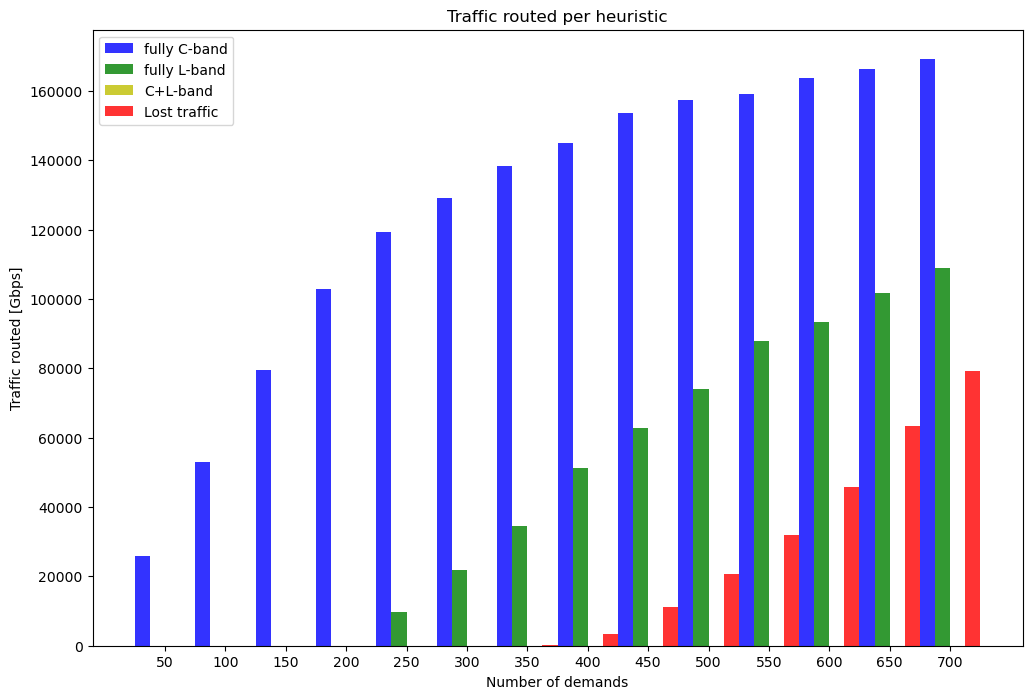

In [17]:
from ortools.linear_solver import pywraplp

channelPerBand = 96 #at 50GHz

biggertopology = True # True = continental, False = national
dualband = True # Change this value to set the dualband mode
crossband = False # Change this value to set the crossband mode
n_ksp = 5 # Change this value to set the number of shortest paths
plot_usage = False
edge_usage = False
sort_demands = True
discrete_rate_demands = True

 
# mod = 7 # Change this value to set a different mode
# datarate, entropy, spacing, reach = set_parameters(mod)

if dualband:
    if biggertopology:
        G = get_network_rwa_json_dualband("continental.json", channelPerBand)
    else:
        G = get_network_rwa_json_dualband("national.json", channelPerBand)    
else:
    if biggertopology:
        G = get_network_rwa_json("continental.json", channelPerBand)   
    else:
        G = get_network_rwa_json("national.json", channelPerBand)
    
# nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

heuristicResults = []
num_iteration = 15

cumulative_c_traffic = 0
cumulative_l_traffic = 0
cumulative_c_l_traffic = 0
cumulative_total_traffic = 0

total_demands = 0
total_demands_routed = 0
cumulative_lost_traffic = 0
demand_at_a_time = 50
for increment in range(1, num_iteration):
    TM = generate_demands(G, demand_at_a_time, sort_demands, discrete_rate_demands)
    print(f"\nTM: {TM}")
    n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic = runHeuristic(G, TM, 
                                                                            num_spectrum=0, 
                                                                            ksp_depth=n_ksp,
                                                                            plot_usage=plot_usage, 
                                                                            n_wavelengths=channelPerBand,
                                                                            modTable=data_table,
                                                                            dualband=dualband,
                                                                            crossband=crossband)
    cumulative_c_traffic += traffic_c
    cumulative_l_traffic += traffic_l
    cumulative_c_l_traffic += traffic_c_l
    cumulative_lost_traffic += lost_traffic
    cumulative_total_traffic = cumulative_c_traffic + cumulative_l_traffic + cumulative_c_l_traffic + cumulative_lost_traffic
    total_demands += demand_at_a_time
    total_demands_routed += n_routed
    blocked_percentage = 100 * (1 - total_demands_routed / total_demands)
    blocked_traffic = 100 * (cumulative_lost_traffic / cumulative_total_traffic)
    heuristicResults.append((n_routed, all_routed, cumulative_c_traffic, cumulative_l_traffic, cumulative_c_l_traffic, cumulative_lost_traffic))

    print('--------------------------------------------------------------------------------------------------------------------')
    print(f'We routed a total of {cumulative_c_traffic+cumulative_l_traffic} Gbps of traffic out of a total of {cumulative_l_traffic+cumulative_c_traffic+cumulative_lost_traffic} Gpbs')
    print(f'We blocked {total_demands-total_demands_routed} demands out of {total_demands}, representing {round(blocked_percentage,2)}% of requests')
    print(f'That represents a percentage of {round(blocked_traffic,2)}%  lost traffic')
    print('_____________________________________________________________________________________________________________________')


# Print the results with matplotlib in a histogram with three bars per each heuristicResults tuple, one bar per each band and one for lost traffic
# The bar will represent the traffic routed on c band and l band
# The x axis will represent the number of demands
# The y axis will represent the traffic routed
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25 # Adjust the bar width to fit all bars without overlapping
index = np.arange(len(heuristicResults))  # Assuming heuristicResults is a list
opacity = 0.8

rects1 = plt.bar(index, [traffic_c for n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic in heuristicResults], bar_width,
                 alpha=opacity,
                 color='b',
                 label='fully C-band')

rects2 = plt.bar(index + bar_width, [traffic_l for n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic in heuristicResults], bar_width,
                 alpha=opacity,
                 color='g',
                 label='fully L-band')

rects4 = plt.bar(index + 2 * bar_width, [traffic_c_l for n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic in heuristicResults], bar_width,
                 alpha=opacity,
                 color='y',
                 label='C+L-band')

rects3 = plt.bar(index + 3 * bar_width, [lost_traffic for n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic in heuristicResults], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Lost traffic')

plt.xticks(index + 1.5 * bar_width, [(i + 1) * demand_at_a_time for i in index])

plt.xlabel('Number of demands')
plt.ylabel('Traffic routed [Gbps]')
plt.title('Traffic routed per heuristic')
plt.legend()

# print(f'heuristicResults: {heuristicResults}')
print('____________________________________________________________________________________')
print('SUMMARY:\n')
print(f'We routed a total of {cumulative_c_traffic+cumulative_l_traffic} Gbps of traffic out of a total of {cumulative_l_traffic+cumulative_c_traffic+cumulative_lost_traffic} Gpbs')
print(f'We blocked {total_demands-total_demands_routed} demands out of {total_demands}, representing {round(blocked_percentage,2)}% of requests')
print(f'That represents a percentage of {round(blocked_traffic,2)}%  lost traffic')
print('____________________________________________________________________________________')
if edge_usage:
    for edge in G.edges:
        if dualband:
            print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nC-Band wavelength utilization: {G.edges[edge]["c_available_wavelengths"]}\nL-Band wavelength utilization: {G.edges[edge]["l_available_wavelengths"]}')
        else:
            print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nWavelength utilization: {G.edges[edge]["available_wavelengths"]}')
